<a href="https://colab.research.google.com/github/raahatg21/Signature_Verification/blob/raahatg21-siamese/sigmodelv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signature Verification v2.4 

## Using Siamese Network and self-preprocessing the data

##Workflow:

###Data Preprocessing
* go to the required directories
* select pairs of images

* preprocess pairs
  * load images
  * convert to np array
  * format to correct size, etc
  * join them to form a pair and append in the list of pairs

* add the corresponding label (genuine-genuine pair or genuine-forged pair)
* divide into: 40 authors training, 7 validation, 7 testing
* shuffle, but labels must remain corresponding to the right pairs
        
###Model Accessories
* define eucledian distance
* define loss
* define accuracy measure
        
###Defining the Model
* define one branch
* make two branches and merge them
* mark correct input-ouput
* compile the model
        
###Train and Evaluate

In [0]:
''' Directory structure:
    Data_for_3
    --> 54 Authors (013, 017, 018 etc)
        --> Genuine (24 sign each)
        --> Forged (~12 sign each)
'''

' Directory structure:\n    Data_for_3\n    --> 54 Authors (013, 017, 018 etc)\n        --> Genuine (24 sign each)\n        --> Forged (~12 sign each)\n'

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [0]:
!pip install -I keras==2.1.6

    100% |████████████████████████████████| 348kB 27.0MB/s 
    100% |████████████████████████████████| 276kB 17.0MB/s 
    100% |████████████████████████████████| 26.6MB 1.7MB/s 
    100% |████████████████████████████████| 17.3MB 3.0MB/s 
    100% |████████████████████████████████| 2.8MB 13.5MB/s 
  Running setup.py bdist_wheel for pyyaml ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/ad/da/0c/74eb680767247273e2cf2723482cb9c924fe70af57c334513f
Successfully built pyyaml
yellowbrick 0.9 has requirement matplotlib<3.0,>=1.5.1, but you'll have matplotlib 3.0.2 which is incompatible.
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
thinc 6.12.1 has requirement wrapt<1.11.0,>=1.10.0, but you'll have wrapt 1.11.1 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.1 which is incompatible.
jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-to

In [0]:
import keras
keras.__version__  # Make sure it is 2.1.6

Using TensorFlow backend.


'2.1.6'

In [0]:
# Mounting Google Drive

from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import tensorflow as tf

from keras import layers, optimizers, regularizers
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras import backend as K
from keras.models import Model   
from keras.layers import * 

In [0]:
# !ls "/content/drive/My Drive"
#!ls "/content/drive/My Drive/Data_for_3"

In [0]:
BASE_DIR = "/content/drive/My Drive/Data_for_3"  # when using Google Drive
#BASE_DIR = "/home/raahat/Documents/Signet/Datasets/Data_for_3"  # when using local files

In [0]:
# Some functions for loss and accuracy

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [0]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [0]:
def compute_accuracy_roc(predictions, labels):  
    dmax = np.max(predictions)
    dmin = np. ehmin(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)

    step = 0.01
    max_acc = 0
    
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d

        tpr = float(np.sum(labels[idx1] == 1)) / nsame
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)

        if (acc > max_acc):
            max_acc = acc

        return max_acc

In [0]:
def compute_accuracy(predictions, labels):  
    return labels[predictions.ravel() < 0.5].mean()

In [0]:
# Parameters and Variables

height =  256
width =  256
# image is greyscaled (channels = 1)
input_shape = (height, width, 1)

epochs = 40
batch_size = 128

In [0]:
# Getting and preprocessing the data

authors = os.listdir(BASE_DIR)

In [0]:
# Training Data

tr_pairs = []
tr_labels = []

for counter, author in enumerate(authors[0:6], 1):  # [0:41]
    gen_dir = os.path.join(BASE_DIR, author, 'Genuine')
    for_dir = os.path.join(BASE_DIR, author, 'Forged')

    gen_list = os.listdir(gen_dir)
    for_list = os.listdir(for_dir)

    gen_num = len(gen_list)
    for_num = len(for_list)

    # Genuine-Genuine
    for i in range(gen_num):
        for j in range(i+1, gen_num):
            file1 = gen_list[i]
            file2 = gen_list[j]
            
            try:
              img1 = image.load_img(os.path.join(gen_dir, file1), grayscale = True, target_size=(height, width))
              img1 = image.img_to_array(img1)
              img1 = img1.astype('float32')
              img1 /= 255

              img2 = image.load_img(os.path.join(gen_dir, file2), grayscale = True, target_size=(height, width))
              img2 = image.img_to_array(img2)
              img2 = img2.astype('float32')
              img2 /= 255

              tr_pairs += [[img1, img2]] 
              tr_labels += [1]  
            
            except:
              a = 2  # dummy

    # Genuine-Forged
    for k in range(gen_num):
        for l in range(for_num):
            file3 = gen_list[k]
            file4 = for_list[l]
            
            try:
              img3 = image.load_img(os.path.join(gen_dir, file3), grayscale = True, target_size=(height, width))
              img3 = image.img_to_array(img3)
              img3 = img3.astype('float32')
              img3 /= 255

              img4 = image.load_img(os.path.join(for_dir, file4), grayscale = True, target_size=(height, width))
              img4 = image.img_to_array(img4)
              img4 = img4.astype('float32')
              img4 /= 255

              tr_pairs += [[img3, img4]]  
              tr_labels += [0]  
            
            except:
              a = 2
              
    print(counter, len(tr_pairs))

1 564
2 1128
3 1692
4 2256
5 2916
6 3384


In [0]:
# Validation Data

vl_pairs = []
vl_labels = []

for counter, author2 in enumerate(authors[41:45], 1):  # [41:48]
    gen_dir2 = os.path.join(BASE_DIR, author2, 'Genuine')
    for_dir2 = os.path.join(BASE_DIR, author2, 'Forged')

    gen_list2 = os.listdir(gen_dir2)
    for_list2 = os.listdir(for_dir2)

    gen_num2 = len(gen_list2)
    for_num2 = len(for_list2)

    # Genuine-Genuine
    for i in range(gen_num2):
        for j in range(i+1, gen_num2):
            file1 = gen_list2[i]
            file2 = gen_list2[j]
            
            # try
            img1 = image.load_img(os.path.join(gen_dir2, file1), grayscale = True, target_size=(height, width))
            img1 = image.img_to_array(img1)
            img1 = img1.astype('float32')
            img1 /= 255

            img2 = image.load_img(os.path.join(gen_dir2, file2), grayscale = True, target_size=(height, width))
            img2 = image.img_to_array(img2)
            img2 = img2.astype('float32')
            img2 /= 255

            vl_pairs += [[img1, img2]] 
            vl_labels += [1]  
              
            # except

    # Genuine-Forged
    for k in range(gen_num2):
        for l in range(for_num2):
            file3 = gen_list2[k]
            file4 = for_list2[l]

            # try
            img3 = image.load_img(os.path.join(gen_dir2, file3), grayscale = True, target_size=(height, width))
            img3 = image.img_to_array(img3)
            img3 = img3.astype('float32')
            img3 /= 255

            img4 = image.load_img(os.path.join(for_dir2, file4), grayscale = True, target_size=(height, width))
            img4 = image.img_to_array(img4)
            img4 = img4.astype('float32')
            img4 /= 255

            vl_pairs += [[img3, img4]]  
            vl_labels += [0]  
            
            # except
              
    print(counter, len(vl_pairs))

1 564
2 1128
3 1692
4 2352


In [0]:
# Test Data

te_pairs = []
te_labels = []

for counter, author3 in enumerate(authors[48:52], 1):  # [48:]
    gen_dir3 = os.path.join(BASE_DIR, author3, 'Genuine')
    for_dir3 = os.path.join(BASE_DIR, author3, 'Forged')

    gen_list3 = os.listdir(gen_dir3)
    for_list3 = os.listdir(for_dir3)

    gen_num3 = len(gen_list3)
    for_num3 = len(for_list3)

    # Genuine-Genuine
    for i in range(gen_num3):
        for j in range(i+1, gen_num3):
            file1 = gen_list3[i]
            file2 = gen_list3[j]
            
            try:
              img1 = image.load_img(os.path.join(gen_dir3, file1), grayscale = True, target_size=(height, width))
              img1 = image.img_to_array(img1)
              img1 = img1.astype('float32')
              img1 /= 255

              img2 = image.load_img(os.path.join(gen_dir3, file2), grayscale = True, target_size=(height, width))
              img2 = image.img_to_array(img2)
              img2 = img2.astype('float32')
              img2 /= 255

              te_pairs += [[img1, img2]] 
              te_labels += [1] 
              
            except:
              a = 2

    # Genuine-Forged
    for k in range(gen_num2):
        for l in range(for_num2):
            file3 = gen_list2[k]
            file4 = for_list2[l]

            try:
              img3 = image.load_img(os.path.join(gen_dir3, file3), grayscale = True, target_size=(height, width))
              img3 = image.img_to_array(img3)
              img3 = img3.astype('float32')
              img3 /= 255

              img4 = image.load_img(os.path.join(for_dir3, file4), grayscale = True, target_size=(height, width))
              img4 = image.img_to_array(img4)
              img4 = img4.astype('float32')
              img4 /= 255

              te_pairs += [[img3, img4]]  
              te_labels += [0]  
            
            except:
              a = 2
              
    print(counter, len(te_pairs))

1 276
2 552
3 828
4 1104


In [0]:
tr_pairs = np.asarray(tr_pairs)
tr_labels = np.asarray(tr_labels)
vl_pairs = np.asarray(vl_pairs)
vl_labels = np.asarray(vl_labels)
te_pairs = np.asarray(te_pairs)
te_labels = np.asarray(te_labels)

In [0]:
# Defining the model
def siamese_base(input_shape):
    seq = Sequential()
    seq.add(layers.Conv2D(64, (7, 7), activation = 'relu', strides = (2, 2), input_shape = input_shape))  ## kernel_initializer = 'glorot_uniform'
    seq.add(layers.BatchNormalization(epsilon = 1e-06, axis = 3, momentum = 0.9))
    seq.add(layers.MaxPooling2D((3, 3), strides = (2, 2)))
    seq.add(layers.ZeroPadding2D((2, 2), ))

    seq.add(layers.Conv2D(128, (5, 5), activation = 'relu', strides = (1, 1)))  ## kernel_initializer = 'glorot_uniform'
    seq.add(layers.BatchNormalization(epsilon = 1e-06, axis = 1, momentum = 0.9))
    seq.add(layers.MaxPooling2D((3, 3), strides = (2, 2)))
    seq.add(layers.ZeroPadding2D((1, 1), ))

    seq.add(layers.Conv2D(256, (5, 5), activation = 'relu', strides = (1, 1)))  ## kernel_initializer = 'glorot_uniform'
    seq.add(layers.MaxPooling2D((3, 3), strides = (2, 2)))
    seq.add(layers.Dropout(0.3))
    seq.add(layers.ZeroPadding2D((1, 1), ))

    seq.add(layers.Conv2D(256, (3, 3), activation = 'relu', strides = (1, 1)))  ## kernel_initializer = 'glorot_uniform'
    seq.add(layers.MaxPooling2D((3, 3), strides = (2, 2)))
    seq.add(layers.Dropout(0.3))

    seq.add(layers.Flatten())
    seq.add(layers.Dense(1024, kernel_regularizer = regularizers.l2(0.0005), activation = 'relu'))  ## kernel_initializer = 'glorot_uniform'
    seq.add(layers.Dropout(0.5))

    seq.add(layers.Dense(128, kernel_regularizer = regularizers.l2(0.0005), activation = 'relu'))  ## kernel_initializer = 'glorot_uniform'
    print(seq.summary())
    return seq

In [0]:
base_network = siamese_base(input_shape)
input_a = Input(shape = (input_shape))
input_b = Input(shape = (input_shape))
processed_a = base_network(input_a)
processed_b = base_network(input_b)  # Sharing of weights

distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model(inputs = [input_a, input_b], outputs = distance)

rms = optimizers.RMSprop(lr = 1e-4, rho = 0.9, epsilon = 1e-8)
model.compile(loss = contrastive_loss, optimizer = rms)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 125, 125, 64)      3200      
_________________________________________________________________
batch_normalization_1 (Batch (None, 125, 125, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 66, 66, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 128)       204928    
_________________________________________________________________
batch_normalization_2 (Batch (None, 62, 62, 128)       248       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
__________

In [0]:
history = model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_labels, epochs = epochs, batch_size = batch_size, validation_data = ([vl_pairs[:, 0], vl_pairs[:, 1]], vl_labels))

Train on 3384 samples, validate on 2352 samples
Epoch 1/40
3384/3384 [==============================] - 42s 13ms/step - loss: 31.7898 - val_loss: 1.5548
Epoch 2/40
3384/3384 [==============================] - 32s 9ms/step - loss: 1.6039 - val_loss: 1.5547
Epoch 3/40
3384/3384 [==============================] - 32s 9ms/step - loss: 1.2226 - val_loss: 1.4184
Epoch 4/40
3384/3384 [==============================] - 32s 9ms/step - loss: 1.1002 - val_loss: 1.1080
Epoch 5/40
3384/3384 [==============================] - 32s 9ms/step - loss: 1.0230 - val_loss: 1.0498
Epoch 6/40
3384/3384 [==============================] - 32s 9ms/step - loss: 0.9630 - val_loss: 0.9772
Epoch 7/40
3384/3384 [==============================] - 32s 9ms/step - loss: 0.8580 - val_loss: 0.9091
Epoch 8/40
3384/3384 [==============================] - 32s 9ms/step - loss: 0.7489 - val_loss: 0.7535
Epoch 9/40
3384/3384 [==============================] - 32s 9ms/step - loss: 0.6180 - val_loss: 0.6438
Epoch 10/40
3384/3384 [

In [0]:
# model.save(os.path.join(BASE_DIR, 'model2x2.h5'))

In [0]:
epochsh = range(2, 41)
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]

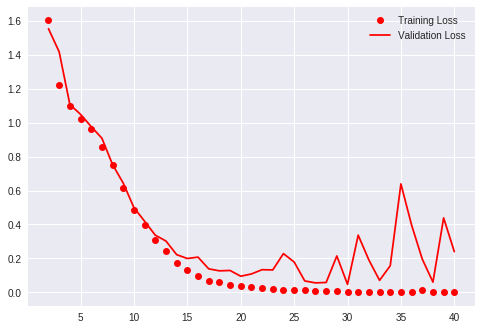

In [0]:
# Training vs Validation Loss

plt.plot(epochsh, loss, 'ro', label = 'Training Loss')
plt.plot(epochsh, val_loss, 'r', label = 'Validation Loss')
plt.legend()
plt.show()

In [0]:
pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
acc = model.evaluate([te_pairs[:, 0], te_pairs[:, 1]], te_labels)
te_acc = compute_accuracy(pred, te_labels)
roc_acc = compute_accuracy_roc(pred, te_labels)
print(acc, te_acc, roc_acc)

1104/1104 [==============================] - 4s 4ms/step
0.304880627653683 1.0 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
